# Topic discovery and Sentiment analysis 

Purpose of this project was to utilize various NLP techniques including LDA for topic modeling and perform sentiment analysis on Technology articles collected from The New York Times. Dataset corpus was preprocessed applying various text cleaning techniques using NLTK library. LDA was applied to find the most common topics and PyLDAvis was used to visualize them. Lastly, sentiment analysis was carried out using TextBlob library to get an insight into sentiments hidden in text.

### Initial Setup

In this section we start with installing and importing libraries

In [1]:
#!pip install gensim
#!pip install pyLDAvis==3.2.2 
#!pip install textblob
import nltk
import gensim 
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.tokenize import MWETokenizer, word_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS #gensim has longer list of stop words than NLTK
from gensim import corpora
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np

Importing data that is stored on github 

In [2]:
# Importing the dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/sivosevic/NYTimesNLP/main/TechArticles.csv')
df.head

<bound method NDFrame.head of       Unnamed: 0                                              title  \
0              0     Ty Haney Is Doing Things Differently This Time   
1              1  Washington State Advances Landmark Deal on Gig...   
2              2              Google Suspends Advertising in Russia   
3              3  When Electric Cars Rule the Road, They’ll Need...   
4              4  A coalition of state attorneys general opens a...   
...          ...                                                ...   
1195        1195                                Technology Briefing   
1196        1196                                Technology Briefing   
1197        1197                                Technology Briefing   
1198        1198                                Technology Briefing   
1199        1199                                Technology Briefing   

                                               abstract  
0     The Outdoor Voices founder has a new venture t...  
1

# Preprocessing 1.1

In this section, we are going to combin each article's title and abstract into a single body of lowercase text.

In [3]:
titles = np.array(df['title'])
abstracts = np.array(df['abstract'])

articles = [((str(titles[i]) + ' ' + str(abstracts[i])).lower()) for i in range(len(titles))]
articles[:5]


['ty haney is doing things differently this time the outdoor voices founder has a new venture that aims to reward customers with blockchain-based assets. but do brand loyalists really want nfts?',
 'washington state advances landmark deal on gig drivers’ job status lawmakers have passed legislation granting benefits and protections, but allowing lyft and uber to continue to treat drivers as contractors.',
 'google suspends advertising in russia the move came after a russian regulator demanded that the company stop showing ads with what the regulator claimed was false information about the invasion of ukraine.',
 'when electric cars rule the road, they’ll need spots to power up a wireless infrastructure company is betting it can figure out how to locate and install charging stations for a growing wave of new vehicles.',
 'a coalition of state attorneys general opens an investigation into tiktok. the group is looking into the chinese-owned video site for the harms it may pose to younger 

In [4]:
len(articles)

1200

# Preprocessing 1.2

We will perform the following steps:
##### Tokenization was performed to split the text into sentences and the sentences into words. 
##### All punctuations are removed
##### All stopwords are removed and tokens that have fewer than 4 characters are removed
##### Words are lemmatized:words in third person are changed to first person and verbs in past and future tenses are changed into present
##### Collocation was performed to find most frequent bigrams



In [19]:
#stopwords= set(nltk.corpus.stopwords.words('english')) 
# remove punctuations
stopwords = set(STOPWORDS)
#more_stopwords = {'technology','company','percent','briefing','million','service','internet','facebook','people'}
#stopwords = stopwords.union(more_stopwords)
def remove_punctuation(corpus):
    punctuations = r".,\"-\\/#!?$%\^&\*;:{}=\-_'~()"    
    filtered_corpus = [token for token in corpus if (not token in punctuations)]
    return filtered_corpus
#remove stop words and remove tokens with lenght less than 4 characters
def apply_stopwording(corpus, min_len):
    black_list = ['technology','company','percent','briefing','million','service','internet']
    #filtered_corpus = [token for token in corpus if (not token in stopwords and len(token)>4)]
    filtered_corpus = [token for token in corpus if (not token in stopwords and not token in black_list and len(token)>4)]
    return filtered_corpus
# apply lemmatization
def apply_lemmatization(corpus):
    lemmatizer = nltk.WordNetLemmatizer()
    normalized_corpus = [lemmatizer.lemmatize(token) for token in corpus]
    return normalized_corpus
#find most common bigrams
def getCollocations(text, min_freq, coll_num):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finderb = BigramCollocationFinder.from_words(text)
    finderb.apply_freq_filter(min_freq)
    collocations = finderb.nbest(bigrams.pmi, coll_num)
    return collocations 

def replaceCollocationsInText(text,collocations):
    first = [t[0]for t in collocations]
    second = [t[1] for t in collocations]

    dtokens = []
    i = 0
    while i<=(len(text)-1):
        try:
            idx1 = first.index(text[i])
            if (text[i+1]==second[idx1]):
                dtokens.append(first[idx1]+"_"+second[idx1]) 
        except:
            dtokens.append(text[i])
            pass
        i=i+1
    return dtokens

def processCorpus(corpus_data):
    #The input is an array of unprocessed text documents
    min_frequency = 3 #only grams that appear 3+ times
    num_of_collocations=100 #top 100 
    text=""
    corpus=[]
    tokens =[]
    
    #Extract corpus and preprocess data
    for line in corpus_data:
        t = nltk.word_tokenize(line) #tokenize each article
        doc = nltk.Text(t)
        doc_clean = nltk.Text(apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3)))
        corpus.append(doc_clean)
        tokens.extend(doc_clean.tokens)
        text=text+line
    
    #Identify collocations
    collocations = getCollocations(tokens,min_frequency,num_of_collocations)
    docs = []
    for doc in corpus:
        t = replaceCollocationsInText(doc,collocations)
        if (len(t)>0):
            docs.append(replaceCollocationsInText(doc,collocations))
    return docs

In [20]:
processDocs = processCorpus(articles)
print (len(processDocs))
print (processDocs[0:10])

1098
[['haney', 'thing', 'differently', 'outdoor', 'voice', 'founder', 'reward', 'customer', 'blockchain-based', 'asset', 'brand', 'loyalist'], ['washington', 'state', 'advance', 'landmark', 'driver', 'status', 'lawmaker', 'passed', 'granting', 'benefit', 'protection', 'allowing', 'continue', 'treat', 'driver', 'contractor'], ['google', 'suspends', 'advertising', 'russia', 'russian', 'regulator', 'demanded', 'showing', 'regulator', 'claimed', 'false', 'information', 'invasion', 'ukraine'], ['electric', 'spot', 'power', 'infrastructure', 'betting', 'figure', 'locate', 'install', 'charging', 'station', 'growing', 'vehicle'], ['coalition', 'state', 'attorney_general', 'general', 'open', 'investigation', 'tiktok', 'group', 'looking', 'chinese-owned', 'video', 'harm', 'younger', 'user'], ['million', 'crypto', 'start-ups', 'name', 'necessary', 'investor', 'money', 'pseudonymous', 'developer', 'capitalist', 'founder', 'learning', 'name', 'happens'], ['russia', 'intensifies', 'censorship', 'ca

# Topic Discovery with LDA

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 
We start with converting document into the bag-of-words dictionary format.

In [8]:
doc = nltk.Text(processDocs)
dictionary = gensim.corpora.Dictionary(processDocs)
corpus = [dictionary.doc2bow(doc) for doc in processDocs]
dictionary.token2id

{'asset': 0,
 'blockchain-based': 1,
 'brand': 2,
 'customer': 3,
 'differently': 4,
 'founder': 5,
 'haney': 6,
 'loyalist': 7,
 'outdoor': 8,
 'reward': 9,
 'thing': 10,
 'voice': 11,
 'advance': 12,
 'allowing': 13,
 'benefit': 14,
 'continue': 15,
 'contractor': 16,
 'driver': 17,
 'granting': 18,
 'landmark': 19,
 'lawmaker': 20,
 'passed': 21,
 'protection': 22,
 'state': 23,
 'status': 24,
 'treat': 25,
 'washington': 26,
 'advertising': 27,
 'claimed': 28,
 'demanded': 29,
 'false': 30,
 'google': 31,
 'information': 32,
 'invasion': 33,
 'regulator': 34,
 'russia': 35,
 'russian': 36,
 'showing': 37,
 'suspends': 38,
 'ukraine': 39,
 'betting': 40,
 'charging': 41,
 'electric': 42,
 'figure': 43,
 'growing': 44,
 'infrastructure': 45,
 'install': 46,
 'locate': 47,
 'power': 48,
 'spot': 49,
 'station': 50,
 'vehicle': 51,
 'attorney_general': 52,
 'chinese-owned': 53,
 'coalition': 54,
 'general': 55,
 'group': 56,
 'harm': 57,
 'investigation': 58,
 'looking': 59,
 'open': 6

Now we can run LDA 

In [9]:
#here asking LDA to extract 8 topics in the data and :

topic_number=6
topic_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=topic_number, id2word = dictionary, passes = 20)
topics = topic_model.print_topics(num_words = 6)

for topic in topics:
    print (topic)

(0, '0.007*"social" + 0.007*"internic" + 0.006*"trademark" + 0.005*"medium" + 0.005*"domain" + 0.005*"twitter"')
(1, '0.015*"share" + 0.010*"sale" + 0.010*"software" + 0.009*"quarter" + 0.009*"yesterday" + 0.008*"billion"')
(2, '0.005*"apple" + 0.004*"microsoft" + 0.004*"safety" + 0.004*"executive" + 0.003*"change" + 0.003*"chief"')
(3, '0.017*"holmes" + 0.011*"elizabeth" + 0.009*"trial" + 0.008*"theranos" + 0.006*"company" + 0.004*"medium"')
(4, '0.013*"briefing" + 0.007*"company" + 0.006*"china" + 0.005*"state" + 0.005*"board" + 0.004*"government"')
(5, '0.005*"space" + 0.005*"change" + 0.005*"tesla" + 0.004*"medium" + 0.004*"chief" + 0.004*"software"')


### Visualize Topics
Here we will use pyLDAvis library to vizualy see tipics that were discovered

In [10]:
%matplotlib inline
lda_vis = pyLDAvis.gensim.prepare(topic_model,corpus,dictionary,sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.save_html(lda_vis, 'LDA_vis.html') #save 
pyLDAvis.display(lda_vis)


/Users/SolidSnake/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Sentiment Analysis 

Sentiment Analysis is a process of analyzing data that can help us get insighfuly informations about opinion,emotions and mood that are hidden in text

We will start here with creating df from pre-processed documents


In [11]:
# Each columns is one document 
data_2 = pd.DataFrame.from_records(processDocs).transpose()
data_2.head()

,0,1,2,3,4,5,6,7,8,9,...,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096
0,haney,washington,google,electric,coalition,million,russia,block,russia,china,...,hardware,mlife,hardwaresolectron,original,hardwarea,peopleat,warns,provider,telecommunicationsnokia,retrenchment
1,thing,state,suspends,spot,state,crypto,intensifies,billion,cryptocurrency,spacex,...,advanced_micro,draw,buying,incubator,hewlett,executive,lower,explorer,amber,once-highflying
2,differently,advance,advertising,power,attorney_general,start-ups,censorship,unitedhealth,blunt,source,...,micro,super,c-mac,pulling,director,join,sale,goto.com,network,investment
3,outdoor,landmark,russia,infrastructure,general,name,campaign,group,force,rocket,...,issue,traffic,billion,idealab,criticized,appointed,online,announced,nokia,holding
4,voice,driver,russian,betting,open,necessary,pressuring,agency,sanction,crashing,...,warning,annual,c-mac,prominent,letter,david,infor-,yesterday,finnish,investor


To carry out sentiment Analysis we will use TextBlob library. As a result we will have polarity and subjectivity of a sentence.

Values for polarity are between 1 and -1 where 1 defines a positive sentiment and -1 defines negative sentiment.

Values for subjectivity are between 0 and 1 where value closet to 1 means that text contains personal opinion rather than fact.

In [12]:
# Creating a function to get the Subjectivity and Polarity:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# creating a function to create polarity. It tells how positive or negative the text is:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

polarities = []
subjectivities = []

for article in processDocs:
    article_str = ' '.join(article)
    p = getPolarity(article_str) # polarity for the current article
    s = getSubjectivity(article_str)
    polarities.append(p)
    subjectivities.append(s)
    
print(' '.join(processDocs[250]), polarities[250])

green-energy draw american underdog bolivia lithium chinese russian industrial giant mineral deposit vital electric texas entrepreneur strategy 0.02


Here we are creating new df to display content and values for polarity and subjectivity

In [13]:
articles_list = list(map(lambda article: ' '.join(article), processDocs))
d = {
    'content': articles_list,
    'polarity': polarities,
    'subjectivity': subjectivities
}

newdf = pd.DataFrame(d)
newdf.head()

,content,polarity,subjectivity
0,haney thing differently outdoor voice founder ...,0.000000,0.600000
1,washington state advance landmark driver statu...,0.000000,0.000000
2,google suspends advertising russia russian reg...,-0.200000,0.300000
3,electric spot power infrastructure betting fig...,0.000000,0.000000
4,coalition state attorney_general general open ...,0.016667,0.333333


Next we are creating new column 'analysis' that is generated based on polarity values. Negative (polarity <0), Neutral (polarity=0) ,Positive (polarity >0)

In [14]:
#Creating a function to compute negative (-1), Neutral (0) and Positive (+1) Analysis
def getAnalysis(score):  
    if score <0:
          return 'Negative'
    elif score <=0:
          return 'Neutral'
    else:
          return 'Positive'

# Adding a new column analysis with positive and negative:
newdf['analysis'] = newdf['polarity'].apply(getAnalysis)

# Checking the dataset with new column:
newdf.head()

,content,polarity,subjectivity,analysis
0,haney thing differently outdoor voice founder ...,0.000000,0.600000,Neutral
1,washington state advance landmark driver statu...,0.000000,0.000000,Neutral
2,google suspends advertising russia russian reg...,-0.200000,0.300000,Negative
3,electric spot power infrastructure betting fig...,0.000000,0.000000,Neutral
4,coalition state attorney_general general open ...,0.016667,0.333333,Positive


Here we are going to take a look into sentenced that are classified as a positive 

In [15]:
# Printing Positive analysis: 
print('Printing positive sentiments:\n')
j=1
sortedDF = newdf.sort_values(by=['polarity']) #Sort the content
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['content'][i])
        print()
        j= j+1

Printing positive sentiments:

1) coalition state attorney_general general open investigation tiktok group looking chinese-owned video harm younger user

2) block billion unitedhealth group agency lawsuit health latest biden_administration quash corporate consolidation

3) reveal spacex starship rocket founder private space rehashed broad vision colonizing provided clear detail starship orbit

4) studied clash nature culture america landmark machine garden explored contradiction pastoral ideal helped define field american study

5) shifting narrative crisis safety hazelbaker executive helped ride-hailing weather assault accusation change practice fresh messaging

6) hollywood entrepreneur limited series dropout wecrashed super pumped culture saturated ripped-from-the-headlines tale self-immolating mogul

7) climate scientist ready strike evidence global warming piling nation acting researcher asking difference report

8) compatibility blockchain according bosworth chief officer vision 

Here we are going to take a look into sentenced that are classified as a negative

In [16]:
# Printing Negative analysis: 
print('Printing negative Sentiments:\n')
j=1
sortedDF = newdf.sort_values(by=['polarity']) #Sort the content
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['analysis'][i] == 'Negative'):
    print(str(j) + ') '+ sortedDF['content'][i])
    print()
    j= j+1

Printing negative Sentiments:

1) google suspends advertising russia russian regulator demanded showing regulator claimed false information invasion ukraine

2) russia intensifies censorship campaign pressuring giant google apple warned comply vulnerable kremlin censorship demand

3) china spacex source rocket crashing developer astronomy software cause crater gotten wrong

4) softbank deputy leaving billion-dollar dispute marcelo claure close confidant softbank founder played singular japanese conglomerate seeking roughly billion year

5) crypto enthusiast match angry gamers publisher offering skeptical gamers smell moneymaking scheme fighting

6) opensea valued billion round funding blockchain start-up talked silicon_valley valley tuesday raised venture_capital capital

7) award company stepped housing criminal whistle-blower mixed

8) florida lawmaker advance homophobia desantis so-called teach wrong thing expect approved

9) beeple changed artist changed hardly

10) strike elite vi

If we wants to see ratio between positive,negative and neutral sentiments we can plot on graph

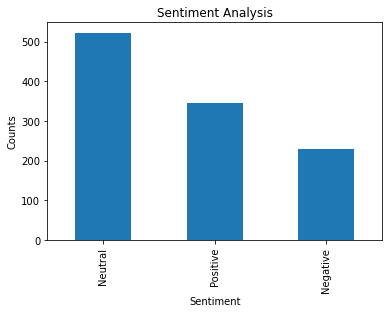

In [17]:
# Plotting and visualizing the counts:
#%matplotlib inline 
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
newdf['analysis'].value_counts().plot(kind = 'bar')
plt.show()

Here we are going to use WordCloud to vizualize distributions of most frequent words

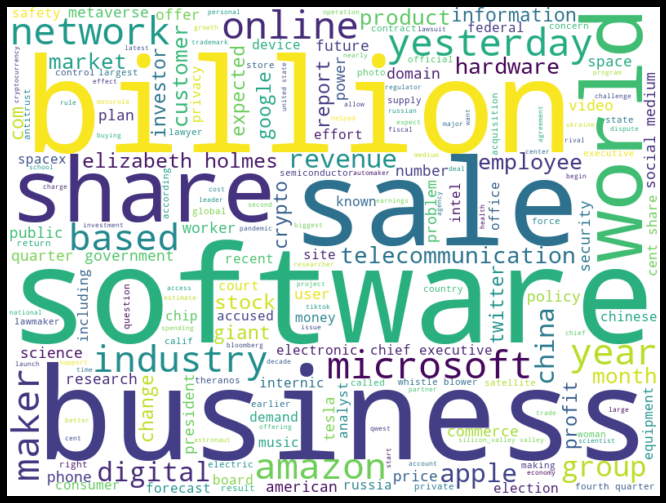

In [18]:
# To see the distribution of the sentiments word cloud is created:
all_articles = ' '.join([content for content in newdf['content']])
wordcloud = WordCloud(stopwords=stopwords, background_color='white',width = 800, height = 600, random_state = 21, max_font_size = 200).generate(all_articles)
plt.figure(figsize=(16,9), facecolor='k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.savefig('WordCloud.png')
#plt.clf()
plt.axis('off')
plt.show()

In this notebook we performed topic discovery and sentiment analysis on articles that were web scraped using NY Times API 